# Проект "Определение перспективного тарифа для телеком компании"

## Вступление
Для оператора сотовой связи "Мегалайн" необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. Всего в выборке данные 500 пользователей: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год.

На данной выборке проведем анализ поведения клиентов и сделаем вывод, какой тариф лучше.

## Шаг 1. Изучим данные

In [12]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

# прочитаем все файлы и загрузим датасеты

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

tariffs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


В ходе изучения данных, были обнаружены одинаковые наименования столбцов: название столбца "ID" были использованы во таблицах со звонками, сообщениями, интернет трафиком. Для удобства дальнейшей работы, произведем замену названий этих столбцов. 

In [13]:
calls.rename(columns={'id':'id_calls'}, inplace=True)
internet.rename(columns={'id':'id_internet'}, inplace=True)
messages.rename(columns={'id':'id_messages'}, inplace=True)
tariffs.rename(columns={'tariff_name':'tariff'}, inplace=True)

## Шаг 2. Подготовим данные

Добавим к датафрйему с данными пользователей информацию о тарифе.

In [14]:
# добавили к каждому пользователю информацию по тарифу
users1 = users.merge(tariffs, on='tariff', how='left')

# переведем включеные Мб в Гб, переименуем столбец
users1['mb_per_month_included'] = users1['mb_per_month_included']/1024
users1 = users1.rename(columns={'mb_per_month_included':'Gb_included'})

users2 = users1[['tariff', 'user_id', 'messages_included', 'Gb_included', 'minutes_included',
       'rub_monthly_fee', 'rub_per_gb', 'rub_per_message', 'rub_per_minute','city']]
users2.sample(5)

,tariff,user_id,messages_included,Gb_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,city
264,smart,1264,50,15.0,500,550,200,3,3,Хабаровск
439,smart,1439,50,15.0,500,550,200,3,3,Орёл
381,ultra,1381,1000,30.0,3000,1950,150,1,1,Москва
428,smart,1428,50,15.0,500,550,200,3,3,Новосибирск
306,smart,1306,50,15.0,500,550,200,3,3,Чита


Преобразуем датафрейм с данными по звонкам пользователей:
- округлим длительность звонков до целого числа в большую сторону
- очень короткие звонки (0.0 мин) заменим на минутный звонок, так как плата взимается за целую минуту
- преобазуем число длительность звонков в целочисленный тип
- добавим информацию о месяце, в котором был совершен звонок

- создадим сводную таблицу по пользователям с информацией о звонках в каждом месяце: количество минут, количество звонков

In [15]:

# переведем звонки в мин, округлив значения в большую сторону
calls['duration'] = calls['duration'].apply(np.ceil)

# заменим 0.0 значения на 1 (округляем самые минимальные значения в большую сторону)
calls['duration'].replace(0.0, 1, inplace = True) 
calls['duration'].astype('int')

# добавим информацию о месяце звонка
calls['month'] = pd.DatetimeIndex(calls['call_date']).month
calls['duration'] = calls['duration'].astype('int')

# сведем данные по каждому пользователю в единую талиблицу
call = calls.pivot_table(index = ['month','user_id'], values = 'duration', aggfunc = (['sum', 'count'])).reset_index()
call.sample(5)

,month,user_id,sum,count
,,,duration,duration
1295,8,1233,684,93
2673,11,1464,612,79
1584,9,1151,387,55
633,6,1049,530,76
2042,10,1241,232,32


Преобразуем датафрейм с информацией о сообщениях пользователей:
- добавим к сообщению информацию о месяце
- создадим сводную таблицу сообщений для каждого пользователя по месяцам, где посчитаем кол-во сообщений в месяц

In [16]:
# добавим информацию о месяце, когда было отправлено сообщение
messages['month'] = pd.DatetimeIndex(messages['message_date']).month

# сведем данные о сообщениях в одну таблицу - по месяцам и пользователям.
messages1 = messages.pivot_table(index = ['month','user_id'], aggfunc = 'count').reset_index()
messages1.drop('message_date', axis='columns', inplace=True)

# переименуем столбец, в котором отображено количество сообщений
messages1.rename(columns={'id_messages':'messages_count'}, inplace=True)
messages1.sample(3)


,month,user_id,messages_count
418,5,1251,96
106,3,1011,4
2465,12,1193,26


Преобразуем датафрейм с информацией о трафике пользователей:
- добавим к каждому выходу в интернет информацию о месяце
- создадим сводную таблицу для каждого пользователя по месяцам, где посчитаем суммарный трафик

In [17]:
# добавим информацию о месяце, когда происходила интернет сессия
internet['month'] = pd.DatetimeIndex(internet['session_date']).month

# переведем Мб в Гб
internet['mb_used'] = internet['mb_used']/1024


# сведем данные об интернет сессиях в таблицу по пользователям и месяцам
internet1 = internet.pivot_table(index = ['month','user_id'], values = 'mb_used', aggfunc = 'sum').reset_index()


# округлили до Гб в большую сторону
internet1['mb_used'] = internet1['mb_used'].apply(np.ceil)

internet1.sample(5)

,month,user_id,mb_used
2119,10,1313,6.0
2795,12,1073,16.0
442,5,1086,17.0
1912,10,1057,14.0
1844,9,1476,19.0


Сведем все полученные данные о пользователях и их мобильной активности по месяцам (сообщения, звонки, интернет) в одну таблицу.

In [18]:
# соединим таблицу о звонках с таблицей о сообщениях
allinclusive_0 = call.merge(messages1, on=['user_id','month'], how='outer')

# добавим к таблице информацию о интернет сессиях
allinclusive = allinclusive_0.merge(internet1, on=['user_id','month'], how='outer')

# удалим повторяющиеся столбцы с месяцем и ID пользователя, переименуем "некрасивые" названия столбцов, NaN значения заполним 0.
allinclusive.drop(('month', ''), axis='columns', inplace=True)
allinclusive.drop(('user_id', ''), axis='columns', inplace=True)
allinclusive.rename(columns={('sum', 'duration'):'call_duration', ('count', 'duration'):'call_count'}, inplace=True)
allinclusive = allinclusive.fillna(0)
allinclusive.rename(columns={'mb_used':'Gb_used'}, inplace=True)

# полученную таблицу объединим с таблицей о пользователях и тарифах
df = allinclusive.merge(users2, on = 'user_id', how='left')

df.info()
df.sample(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214 entries, 0 to 3213
Data columns (total 15 columns):
user_id              3214 non-null int64
month                3214 non-null int64
call_duration        3214 non-null float64
call_count           3214 non-null float64
messages_count       3214 non-null float64
Gb_used              3214 non-null float64
tariff               3214 non-null object
messages_included    3214 non-null int64
Gb_included          3214 non-null float64
minutes_included     3214 non-null int64
rub_monthly_fee      3214 non-null int64
rub_per_gb           3214 non-null int64
rub_per_message      3214 non-null int64
rub_per_minute       3214 non-null int64
city                 3214 non-null object
dtypes: float64(5), int64(8), object(2)
memory usage: 401.8+ KB


,user_id,month,call_duration,call_count,messages_count,Gb_used,tariff,messages_included,Gb_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,city
2708,1004,12,136.0,21.0,162.0,18.0,ultra,1000,30.0,3000,1950,150,1,1,Новокузнецк
2071,1276,10,386.0,58.0,29.0,33.0,ultra,1000,30.0,3000,1950,150,1,1,Москва
38,1433,1,468.0,60.0,74.0,10.0,smart,50,15.0,500,550,200,3,3,Подольск
2884,1190,12,459.0,66.0,20.0,12.0,smart,50,15.0,500,550,200,3,3,Москва
785,1358,6,677.0,83.0,55.0,11.0,smart,50,15.0,500,550,200,3,3,Ставрополь


В новую таблицу со всеми данными добавим столбцы, где будет расчитываться стоимость звонков, сообщений, Гб интернета сверх тарифного пакета.

Для этого создадим и применим построчно функцию, которая считает стоимость звонков пользователя сверх пакетного лимита. Создадим новый столбец, куда поместим получившееся значение. Если пользователь уложился в лимит звонков по тарифу, соотв. стоимость звонков сверх лимита = 0.

In [19]:
# функция для подсчета стоимости звонков сверх лимита
def func_calls(data_calls):
    if data_calls['call_duration'] > data_calls['minutes_included']:
        data_calls['call_duration'] = (data_calls['call_duration'] - data_calls['minutes_included'])*data_calls['rub_per_minute']
    else:
        data_calls['call_duration'] = 0
            
    return data_calls['call_duration']
    
df['over_tariff_call'] = df.apply(func_calls, axis = 1)

#------------------------------------------------------------------------------------

# функция для подсчета стоимости интернета сверх лимита
def func_internet(data_internet):
    if data_internet['Gb_used'] > data_internet['Gb_included']:
        data_internet['Gb_used'] = (data_internet['Gb_used'] - data_internet['Gb_included'])*data_internet['rub_per_gb']
    else:
        data_internet['Gb_used'] = 0
            
    return data_internet['Gb_used']
    
df['over_tariff_internet'] = df.apply(func_internet, axis = 1)

#------------------------------------------------------------------------------------

# функция для подсчета стоимости сообщений сверх лимита
def func_messages(data_messages):
    if data_messages['messages_count'] > data_messages['messages_included']:
        data_messages['messages_count'] = (data_messages['messages_count'] - data_messages['messages_included'])*data_messages['rub_per_message']
    else:
        data_messages['messages_count'] = 0
            
    return data_messages['messages_count']
    
df['over_tariff_messages'] = df.apply(func_messages, axis = 1)


df.sample(5)


,user_id,month,call_duration,call_count,messages_count,Gb_used,tariff,messages_included,Gb_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,city,over_tariff_call,over_tariff_internet,over_tariff_messages
2173,1394,10,405.0,62.0,2.0,9.0,smart,50,15.0,500,550,200,3,3,Орёл,0.0,0.0,0.0
1776,1402,9,769.0,96.0,27.0,21.0,ultra,1000,30.0,3000,1950,150,1,1,Пенза,0.0,0.0,0.0
2919,1226,12,159.0,19.0,87.0,16.0,ultra,1000,30.0,3000,1950,150,1,1,Новосибирск,0.0,0.0,0.0
1370,1345,8,282.0,31.0,3.0,24.0,smart,50,15.0,500,550,200,3,3,Москва,0.0,1800.0,0.0
2845,1150,12,659.0,81.0,126.0,17.0,ultra,1000,30.0,3000,1950,150,1,1,Сургут,0.0,0.0,0.0


Далее посчитаем суммарный месячный доход по каждому пользователю, складывающийся из стоимости  превышенных по лимиту звонков, сообщений, интернета, а также абоненсткой платы.

In [20]:
df['income_per_user'] = df['over_tariff_call']+df['over_tariff_internet']+df['over_tariff_messages']+df['rub_monthly_fee']

df.pivot_table(index=('month'), columns='tariff',values='income_per_user', aggfunc=('sum', 'mean','median'))
#df.pivot_table(index=('tariff'), values='income_per_user', aggfunc=('sum', 'mean','median'))


mean               median               sum          
tariff        smart        ultra   smart   ultra     smart     ultra
month                                                               
1        723.352941  1950.000000   550.0  1950.0   24594.0   17550.0
2        835.051724  1975.000000   550.0  1950.0   48433.0   47400.0
3       1178.571429  2014.864865   928.0  1950.0   90750.0   74550.0
4        974.875000  2001.818182   667.0  1950.0  109186.0  110100.0
5       1210.595745  2059.701493  1028.0  1950.0  170694.0  138000.0
6       1218.048780  2039.285714   950.0  1950.0  199760.0  171300.0
7       1240.502488  2118.131868  1007.0  1950.0  249341.0  192750.0
8       1337.612766  2083.177570  1150.0  1950.0  314339.0  222900.0
9       1267.576923  2024.347826   980.0  1950.0  329570.0  232800.0
10      1382.710884  2065.853659  1150.0  1950.0  406517.0  254100.0
11      1362.566456  2092.164179  1174.5  1950.0  430571.0  280350.0
12      1600.697329  2138.848921  1307.0  1950.0  539435.0  297300.0

Из таблицы видно, что пользователи тарифа Смарт часто платят сверх абонентской платы, в то время как пользователи тарифа Ультра платят незначительно выше (по сравнению со Смарт пользователями) своей абон платы.

## Шаг 3. Анализ данных

Создадим сводную таблицу, чтоб определить медиану, среднее значение, дисперсию и стандартное отклонение для звонков, сообщений и объёма интернет-трафика на каждом из тарифов.

In [21]:
df.pivot_table(index=('tariff'),values=('messages_count','Gb_used','call_duration'),aggfunc=('median','mean','std','var'))

Gb_used                             call_duration         \
             mean median       std        var          mean median   
tariff                                                               
smart   16.328847   17.0  5.747061  33.028705    429.450875  435.0   
ultra   19.494416   19.0  9.853511  97.091686    540.779695  532.0   

                                  messages_count                    \
               std            var           mean median        std   
tariff                                                               
smart   194.871174   37974.774628      33.384029   28.0  28.227876   
ultra   325.738740  106105.726823      49.363452   38.0  47.804457   

                     
                var  
tariff               
smart    796.812958  
ultra   2285.266143

Из таблицы видно, что в основном переплаты по тарифу происходят из-за превышения лимита по интернету. Причем пользователи тарифа Смарт превосходят доступный лимит значительно больше, чем пользователи тарифа Ультра.

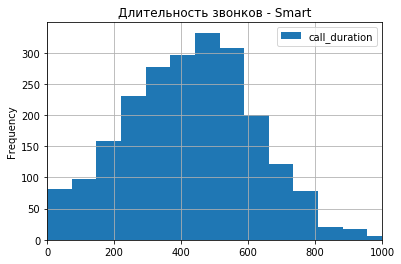

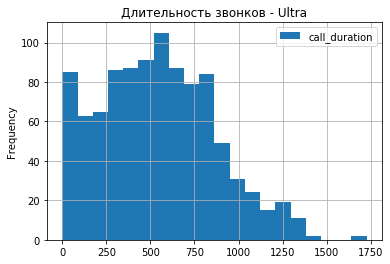

In [22]:
df.query('tariff=="smart"').plot(kind='hist', y='call_duration', title = 'Длительность звонков - Smart', bins=20, grid=True, xlim=(0,1000))
plt.show()
df.query('tariff=="ultra"').plot(kind='hist', y='call_duration', title = 'Длительность звонков - Ultra', bins=20, grid=True)
plt.show()

На графиках видно, что немалая доля пользователей тарифа Смарт превышает абон лимит по звонкам в 500 минут. Пользователи тарифа Ультра в большинстве своем укладываются в лимит 1000 минут.

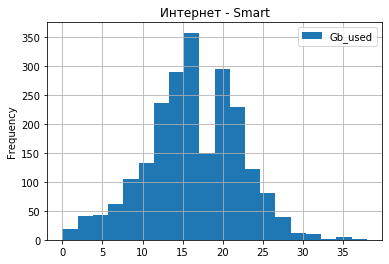

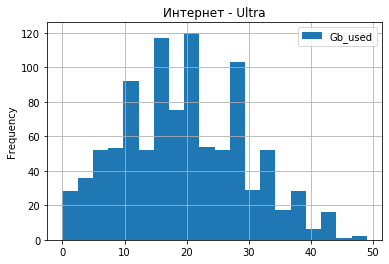

In [23]:
df.query('tariff=="smart"').plot(kind='hist', y='Gb_used', title = 'Интернет - Smart', bins=20, grid=True)
plt.show()
df.query('tariff=="ultra"').plot(kind='hist', y='Gb_used', title = 'Интернет - Ultra', bins=20, grid=True)
plt.show()

Тут видим, что на тарифе Смарт 15 Гб явно маловато, примерно половина пользователей так и норовят превысить этот порог. На Ультра тоже есть те, кто не укладывается в свои 30 Гб, но их меньше.

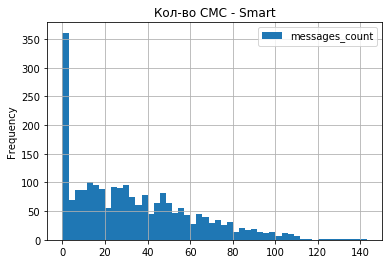

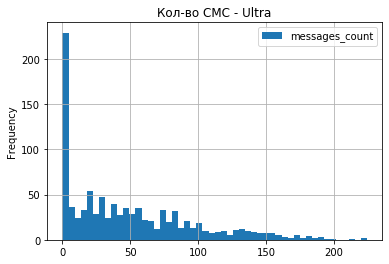

In [24]:
df.query('tariff=="smart"').plot(kind='hist', y='messages_count', title = 'Кол-во СМС - Smart', bins=50, grid=True)
plt.show()
df.query('tariff=="ultra"').plot(kind='hist', y='messages_count', title = 'Кол-во СМС - Ultra', bins=50, grid=True)
plt.show()

На тарифе Смарт опять-таки есть те, кто превышает лимит в 50 сообщений, в то время как на тарифе Ультра лимит 1000 сообщений.

                   Доход от Smart


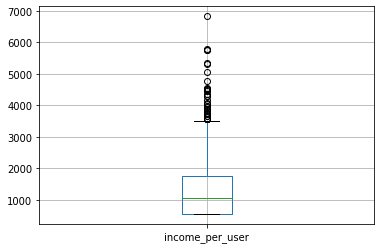

                   Доход от Ultra


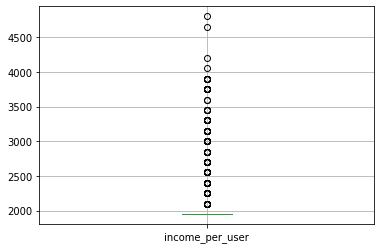

,count,mean,std,min,25%,50%,75%,max
tariff,,,,,,,,
smart,2229.0,1306.949305,827.546207,550.0,553.0,1062.0,1750.0,6824.0
ultra,985.0,2070.152284,376.187114,1950.0,1950.0,1950.0,1950.0,4800.0


In [25]:
df.query('tariff=="smart"').boxplot('income_per_user')
print('                   Доход от Smart')
plt.show()


df.query('tariff=="ultra"').boxplot('income_per_user')
print('                   Доход от Ultra')
plt.show()


df.groupby('tariff')['income_per_user'].describe()


На графиках видим аналогичную картину: пользователи тарифа Смарт значительно переплачивают за услуги мобильного оператора, в отличие от пользователей тарифа Ультра.

## Шаг 4. Проверка гипотез

Проверим гипотезы о том, что тариф и местоположение абонента влияют на выручку оператора.

1) средняя выручка пользователей тарифов «Ультра» и «Смарт» различается;
2) средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов


In [26]:
from scipy import stats as st

"""
            Проверим гипотезу о равенстве средних доходов от пользователей в тарифов Ультра и Смарт.
            H(0): доходы от пользователей тарифов Ультра и Смарт не отличаются
            H(а): доходы от пользователей тарифов Ультра и Смарт отличаются
"""


sample_smart = df.query('tariff == "smart"')['income_per_user'].copy()
sample_smart = sample_smart.dropna()

sample_ultra = df.query('tariff == "ultra"')['income_per_user'].copy()
sample_ultra = sample_ultra.dropna()

alpha = .05

results_1 = st.ttest_ind(sample_smart, sample_ultra)

print('p-значение:', results_1.pvalue)

if (results_1.pvalue < alpha):
    print('Отвергаем нулевую гипотезу, так как доходы от пользователей тарифов Ультра и Смарт отличаются')
else:
    print('Не получилось отвергнуть нулевую гипотезу')
    
print('      ')
print('Средний доход по тарифу Смарт:', sample_smart.mean())
print('Средний доход по тарифу Ультра:', sample_ultra.mean())

p-значение: 1.1153514054806892e-151
Отвергаем нулевую гипотезу, так как доходы от пользователей тарифов Ультра и Смарт отличаются
      
Средний доход по тарифу Смарт: 1306.9493046209063
Средний доход по тарифу Ультра: 2070.1522842639592


In [27]:
def region(row):
    city = row['city']
    
    if city == 'Москва':
        return 'Москва'
    return 'Другое'
    
    
df['region'] = df.apply(region, axis=1)
df


"""
            Проверим гипотезу о равенстве средних доходов от пользователей в Москве и других регионах.
            H(0): доходы от пользователей в Москве и регионах не отличаются
            H(а): доходы от пользователей в Москве и регионах отличаются
"""


sample_moscow = df.query('region == "Москва"')['income_per_user'].copy()
sample_moscow = sample_moscow.dropna()

sample_region = df.query('region == "Другое"')['income_per_user'].copy()
sample_region = sample_region.dropna()

alpha = .05

results_2 = st.ttest_ind(sample_moscow, sample_region)

print('p-значение:', results_2.pvalue)

if (results_2.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Принимаем нулевую гипотезу: доходы от пользователей в Москве и регионах не отличаются')

print('      ')
print('Средний доход по Москве:', sample_moscow.mean())
print('Средний доход по регионам:', sample_region.mean())

p-значение: 0.5923119600753928
Принимаем нулевую гипотезу: доходы от пользователей в Москве и регионах не отличаются
      
Средний доход по Москве: 1556.4746317512274
Средний доход по регионам: 1537.1817134076066


## Шаг 5. Общий вывод

Мы провели исследование поведения пользователей мобильного оператора "Мегалайн".

Было выявлено, что основной статьей расходов клиентов оператора является интернет - пользователям не хватает включенных в абон плату Гб, они часто превышают лимит и платят за дополнительное использование трафика. Особенно те, кто на тарифе Смарт.
Но если пользователи тарифа Ультра переплачивают только по 150р каждый, то пользователи тарифа Смарт превышают свой лимит и платят по 200р за каждый дополнительный Гб.

Получается, что обманичиво дешевая абоненсткая плата в 550р за тариф Смарт оборачивается значительной переплатой (в среднем в 2 раза) за превышение включенных в пакет Гб, минут и сообщений.

Таким обазом, мобильному оператору "Мегалайн" следует уделять больше внимания тарифу Смарт (усилить маркетинговую стратегию, увеличить рекламный бюджет, делать акцент на дешевизне тарифа), так как доходы от него сверх абон платы значительно больше, чем на и так дорогом тарифе Ультра.